In [2]:
import vk
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm
import seaborn as sns
import datetime
import time
%matplotlib inline
#from mpl_toolkits.basemap import Basemap

Загрузили необходимые модули, получаем access_token: ссылки оставляю по большей части для себя (чтобы не потерять их)

https://vk.com/dev/authcode_flow_user

Моё приложение: https://vk.com/editapp?id=5897206&section=options

https://oauth.vk.com/authorize?client_id=5897206&display=popup&redirect_uri=http://matemamoscow.blogspot.com&scope=friends&response_type=code&v=5.62

https://oauth.vk.com/access_token?client_id=5897206&client_secret=wtjopd3zSRI4Z7boNlEN&redirect_uri=http://matemamoscow.blogspot.com&code=9bc8764fc1e29b49ec

Скорее всего, этот процесс можно как-то упростить или автоматизировать, но оставим это пока так.

In [101]:
ACCESS_TOKEN = "5e77cb0add0c758defb0f96d015bd7ae6112c3978275126f5aa76f3df4fd5fcc097376106c400201084a6"
session = vk.Session(access_token=ACCESS_TOKEN)
vkapi = vk.API(session=session)

Функция получения информации о месте: на вход получает объект подключения к API и индекс, до какого объекта требуется запросить. Возвращает pandas.DataFrame с полученными данными.

Внимательное изучение документации (после выпадающих ошибок) говорит о частотных ограничениях:

"К методам API ВКонтакте (за исключением методов из секций secure и ads) можно обращаться не чаще 3 раз в секунду. Если логика Вашего приложения подразумевает вызов нескольких методов подряд, имеет смысл обратить внимание на метод execute. Он позволяет совершить до 25 обращений к разным методам в рамках одного запроса."

Ну что ж, данные для 5000 id будут собираться около получаса.

In [58]:
def get_place_info(vkapi,idx=5000):
    df = pd.DataFrame()
    for x in xrange(1, idx):
        df = df.append(vkapi.places.getById(places=x))
        time.sleep(0.3) 
        if x%100 == 0:
            print x,
    return df

Соберём данные:

In [59]:
data = get_place_info(vkapi)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900


Вообще можно пачками по 25 запросов получать при помощи вк метода execute, это сработает? Но для этого нужно написать скрипт на ВКскрипте, а это довольно уныло и займёт больше получаса со всем этим разбираться. 

Шило в попе это дигноз, напишем быструю реализацию своей функции и потестим, в будущем пригодится:

In [65]:
code_execute = 'var x = 1; return [API.places.getById(x), API.places.getById(x+1)];'
vkapi.execute(code=code_execute)

[False, False]

Пока писал и разбирался данные собрались, но вопрос остаётся открытым - фрейм можно было получить в 25 раз быстрее.

Посмотрим на данные:

In [3]:
data.tail()

,address,checkins,city,country,created,icon,latitude,longitude,pid,title,type,updated
0,Осташковское ш. 1,7,1,1,1280742078,https://vk.com/images/places/restaraunt.png,55.934250,37.657561,4995,Сбарро,3,1.386500e+09
0,Мясницкая К24 1,1,1,1,1280742078,https://vk.com/images/places/restaraunt.png,55.762454,37.635628,4996,Сбарро,3,1.337082e+09
0,Каменноостровский просп. 64,6,2,1,1280742078,https://vk.com/images/places/restaraunt.png,59.974518,30.303382,4997,Le Mon,3,1.444386e+09
0,Б.Палашевский пер. 1К14,0,1,1,1280742078,https://vk.com/images/places/restaraunt.png,55.763630,37.597046,4998,Арт-базар,3,NaN
0,пл. Юности К1,2,1463,1,1280742078,https://vk.com/images/places/restaraunt.png,56.002732,37.209755,4999,Соль и перец,3,1.473998e+09


In [4]:
data.describe()

,checkins,city,country,created,latitude,longitude,pid,type,updated
count,4999.000000,4.999000e+03,4999.0,4.999000e+03,4999.000000,4999.000000,4999.000000,4999.000000,4.593000e+03
mean,16.638728,1.095828e+03,1.0,1.280742e+09,56.068935,41.848142,2500.000000,3.259252,1.417809e+09
std,61.838178,3.210196e+04,0.0,5.130908e+01,3.986579,14.243481,1443.231328,0.438268,5.705482e+07
min,0.000000,1.000000e+00,1.0,1.280742e+09,28.378570,1.694097,1.000000,3.000000,1.280897e+09
25%,1.000000,1.000000e+00,1.0,1.280742e+09,55.640528,30.451619,1250.500000,3.000000,1.355684e+09
50%,3.000000,2.000000e+00,1.0,1.280742e+09,55.778542,37.624494,2500.000000,3.000000,1.425374e+09
75%,11.000000,9.500000e+01,1.0,1.280742e+09,59.858188,43.925272,3749.500000,4.000000,1.474565e+09
max,2299.000000,1.015381e+06,1.0,1.280742e+09,69.066435,131.922657,4999.000000,4.000000,1.488145e+09


Слышал хорошие слова про pickle на занятии, сохраню данные туда:

In [102]:
data.to_pickle('hw1_rogachev.pkl')

Ого, всего 900 килобайт!

In [3]:
data = pd.read_pickle('hw1_rogachev.pkl')

# 1) Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?

Чтобы по city_id понять, где какой город, нужно воспользоваться методом database.getCities() или database.getCitiesById(). Таким образом, отрежем кусок фрейма с city_id==1 и визуализируем:

С shapefile'ом Москвы приходится повозиться: [Тут](http://download.geofabrik.de/russia/central-fed-district.html) файл на 700 с лишним мегабайт, [тут](http://openstreetmapdata.com/) вообще карта всего мира, но, к счастью, какие-то ребята порезали shape от openstreetmapdata [на части](http://gis-lab.info/projects/osm-export.html), этой заготовкой и воспользуемся. Чуть позже я нашёл [это](https://mapzen.com/data/metro-extracts/metro/moscow_russia/), возьму-ка лучше оттуда

In [109]:
plt.figure(figsize=(10,20))
_CENTER_LAT, _CENTER_LON = 40.7254, -73.86105
_LEFT_CORNER_LAT, _LEFT_CORNER_LON =  40.3528, -74.5532
_RIGHT_CORNER_LAT, _RIGHT_CORNER_LON = 41.098, -73.1689
m = Basemap( 
                    projection='cass',
                    lat_0=_CENTER_LAT, lon_0=_CENTER_LON,
                    llcrnrlon=_LEFT_CORNER_LON, llcrnrlat= _LEFT_CORNER_LAT, urcrnrlon=_RIGHT_CORNER_LON, urcrnrlat=_RIGHT_CORNER_LAT)

m.readshapefile('new-york_new-york_osm_roads_gen1', 'areas', color='green')
samples = df.sample(n=1000)
for idx in samples.index:
    x, y = m(samples['dropoff_longitude'][idx],samples['dropoff_latitude'][idx])
    m.plot(x, y, 'o', markersize=2, color='red', alpha=0.8)

NameError: name 'Basemap' is not defined

Устал устанавливать basemap, хоть он и нужен и полезен, пойду путём наименьшего сопротивления: использую folium. Он использует те же данные с OSM, имеет красивый интерфейс и разные плюшки. Если покопаться в документации, то, вероятно, можно даже слои попереключать и оставить только интересующее нас. Меня же устраивает поведение по умолчанию.

In [19]:
mos_center = [55.750475, 37.619020]
mos_min_lat, mos_max_lat = 55.564141, 55.908930
mos_min_lon, mos_max_lon = 37.344362, 37.879945
data_moscow = data[data.latitude.between(mos_min_lat, mos_max_lat) &
                   data.longitude.between(mos_min_lon, mos_max_lon)]
moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=True)
places = data[data.city == 1][['latitude', 'longitude']]
marker_cluster = MarkerCluster(locations=places[['latitude', 'longitude']].values)
marker_cluster.add_to(moscow)
moscow

Тот случай когда и так видно, что в центре заведений гораздо больше, чем на окраинах - по-хорошему это не стоит анализировать методом "eyeball", но я иначе пока не умею с картами работать.

# 2) Типы

Внимательный взгляд на данные показал, что типом 4 шифруются клубы, а типом 3 - рестораны.

In [76]:
pd.value_counts(data.type)

3    3703
4    1296
Name: type, dtype: int64

Чтобы график был красивее, а датафрэйм - понятнее, переведём при помощи лямбда-функции тройки в рестораны, а четвёрки в клубы:

In [58]:
new_format = lambda x : u'ресторан' if x == 3 else u'клуб'
data.type = data.type.map(new_format)
pd.value_counts(data.type)

ресторан    3703
клуб        1296
Name: type, dtype: int64

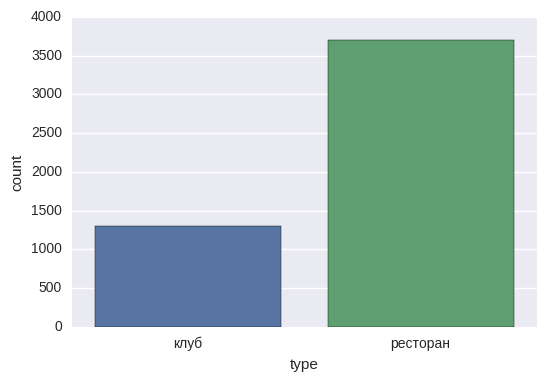

In [59]:
sns.countplot(data.type)

# 3) Чекины и их распределение

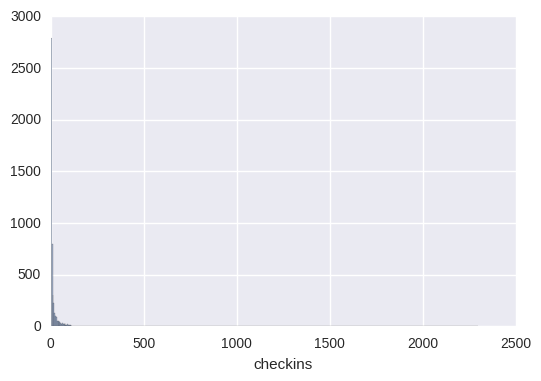

In [5]:
sns.distplot(data.checkins, bins = 500, kde = False)

Ну, вполне справедливый и нечитаемый график

# 4) Постройте box plot по числу чекинов для каждого типа объектов.

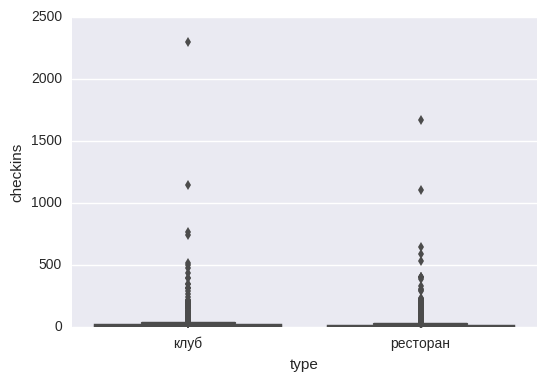

In [63]:
sns.boxplot(y=data.checkins, x=data.type)

В клубах чекинятся чаще, ящик с усами говорит об этом довольно явно

# 5) Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года? 


In [26]:
data.created = pd.to_datetime(data.created,unit='s')

In [27]:
pd.value_counts(data.created)

2010-08-02 09:41:18    2777
2010-08-02 09:40:23     926
2010-08-02 09:39:28     816
2010-08-02 09:39:01     480
Name: created, dtype: int64

ХМ, видимо первые 5000 объектов заносили в 2010-м году каким-то скриптом пачками